# Infer operator computation cost

This notebooks explores a way to predict the cost of operator Transpose based on some features.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

In [3]:
%load_ext mlprodict

## ONNX graph and measures

In [4]:
import numpy
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx.algebra.onnx_ops import OnnxTranspose


def create_onnx_graph(perm=(0, 1, 2, 3), target_opset=14):
    tr = OnnxTranspose('X', perm=perm, output_names=['Y'], op_version=target_opset)
    return tr.to_onnx({'X': FloatTensorType([None] * len(perm))})


onx = create_onnx_graph()

%onnxview onx

In [5]:
from mlprodict.onnxrt import OnnxInference

onx = create_onnx_graph(perm=(1, 0, 3, 2))
oinf = OnnxInference(onx)
inputs = {'X': numpy.full((5, 6, 7, 8), 1, dtype=numpy.float32)}
res = oinf.run(inputs)['Y']
res.shape

(6, 5, 8, 7)

In [6]:
from onnxruntime import InferenceSession
sess = InferenceSession(onx.SerializeToString())
res = sess.run(None, inputs)[0]
res.shape

(6, 5, 8, 7)

In [7]:
from cpyquickhelper.numbers.speed_measure import measure_time

def measure_time_onnx(sess, X, number=50, repeat=30):
    inputs = {'X': X}
    return measure_time(lambda: sess.run(None, inputs), context=dict(sess=sess, inputs=inputs),
                        div_by_number=True, number=number, repeat=repeat)

X = numpy.random.random((3, 224, 224, 4)).astype(numpy.float32)
measure_time_onnx(sess, X)

{'average': 0.004829824666666667,
 'deviation': 0.0016433728065372083,
 'min_exec': 0.0023741520000000096,
 'max_exec': 0.008350742000000012,
 'repeat': 30,
 'number': 50,
 'context_size': 232}

## Simulation to build a database

### Many dimensions, many permutations

In [8]:
from itertools import permutations
from tqdm import tqdm
from pandas import DataFrame


def process_shape(shape, rnd=False, number=50, repeat=30, bar=True):
    X = numpy.random.random(shape).astype(numpy.float32)
    obs = []
    perms = list(permutations(list(range(len(X.shape)))))
    baseline = None
    itergen = perms if (rnd or not bar) else tqdm(perms)
    for perm in itergen:
        if baseline is not None and rnd:
            if random.randint(0, 4) != 0:
                continue
        onx = create_onnx_graph(perm=perm)
        sess = InferenceSession(onx.SerializeToString())
        res = measure_time_onnx(sess, X, number=number, repeat=repeat)
        res['perm'] = perm
        res['shape'] = shape
        if baseline is None:
            baseline = res
        res["ratio"] = res["average"] / baseline["average"]
        res['dim'] = len(shape)
        obs.append(res)
    return DataFrame(obs).sort_values('average')

dfs = []
df = process_shape((12, 13, 15, 18))
dfs.append(df)
df

100%|██████████| 24/24 [00:05<00:00,  4.47it/s]


,average,deviation,min_exec,max_exec,repeat,number,context_size,perm,shape,ratio,dim
4,0.000052,0.000008,0.000043,0.000076,30,50,232,"(0, 3, 1, 2)","(12, 13, 15, 18)",0.630051,4
9,0.000055,0.000012,0.000040,0.000081,30,50,232,"(1, 2, 3, 0)","(12, 13, 15, 18)",0.671793,4
1,0.000064,0.000017,0.000043,0.000126,30,50,232,"(0, 1, 3, 2)","(12, 13, 15, 18)",0.780371,4
18,0.000066,0.000005,0.000057,0.000080,30,50,232,"(3, 0, 1, 2)","(12, 13, 15, 18)",0.806940,4
3,0.000071,0.000023,0.000041,0.000122,30,50,232,"(0, 2, 3, 1)","(12, 13, 15, 18)",0.864305,4
12,0.000078,0.000007,0.000065,0.000102,30,50,232,"(2, 0, 1, 3)","(12, 13, 15, 18)",0.950275,4
0,0.000082,0.000008,0.000074,0.000106,30,50,232,"(0, 1, 2, 3)","(12, 13, 15, 18)",1.000000,4
6,0.000088,0.000011,0.000061,0.000104,30,50,232,"(1, 0, 2, 3)","(12, 13, 15, 18)",1.071314,4
2,0.000097,0.000029,0.000058,0.000141,30,50,232,"(0, 2, 1, 3)","(12, 13, 15, 18)",1.183802,4
8,0.000127,0.000056,0.000066,0.000237,30,50,232,"(1, 2, 0, 3)","(12, 13, 15, 18)",1.545945,4


In [9]:
df = process_shape((43, 44, 45))
dfs.append(df)
df

100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


,average,deviation,min_exec,max_exec,repeat,number,context_size,perm,shape,ratio,dim
2,0.000064,0.000007,0.000058,0.000080,30,50,232,"(1, 0, 2)","(43, 44, 45)",0.929465,3
0,0.000069,0.000015,0.000052,0.000111,30,50,232,"(0, 1, 2)","(43, 44, 45)",1.000000,3
3,0.000069,0.000008,0.000063,0.000093,30,50,232,"(1, 2, 0)","(43, 44, 45)",1.002261,3
1,0.000073,0.000006,0.000063,0.000084,30,50,232,"(0, 2, 1)","(43, 44, 45)",1.055090,3
4,0.000090,0.000010,0.000076,0.000122,30,50,232,"(2, 0, 1)","(43, 44, 45)",1.308952,3
5,0.000340,0.000065,0.000287,0.000495,30,50,232,"(2, 1, 0)","(43, 44, 45)",4.947264,3


In [10]:
df = process_shape((3, 244, 244))
dfs.append(df)
df

100%|██████████| 6/6 [00:02<00:00,  3.00it/s]


,average,deviation,min_exec,max_exec,repeat,number,context_size,perm,shape,ratio,dim
2,0.000111,0.000011,0.000084,0.000129,30,50,232,"(1, 0, 2)","(3, 244, 244)",0.997285,3
0,0.000112,0.000015,0.000095,0.000151,30,50,232,"(0, 1, 2)","(3, 244, 244)",1.000000,3
4,0.000114,0.000008,0.000099,0.000130,30,50,232,"(2, 0, 1)","(3, 244, 244)",1.019782,3
1,0.000143,0.000004,0.000138,0.000160,30,50,232,"(0, 2, 1)","(3, 244, 244)",1.278088,3
3,0.000176,0.000039,0.000127,0.000247,30,50,232,"(1, 2, 0)","(3, 244, 244)",1.575736,3
5,0.000644,0.000060,0.000598,0.000872,30,50,232,"(2, 1, 0)","(3, 244, 244)",5.757424,3


In [11]:
df = process_shape((3, 244, 244, 3), number=15, repeat=15)
dfs.append(df)
df

100%|██████████| 24/24 [00:11<00:00,  2.05it/s]


,average,deviation,min_exec,max_exec,repeat,number,context_size,perm,shape,ratio,dim
3,0.000958,0.000127,0.000837,0.001308,15,15,232,"(0, 2, 3, 1)","(3, 244, 244, 3)",0.773348,4
4,0.001161,0.000215,0.000934,0.001755,15,15,232,"(0, 3, 1, 2)","(3, 244, 244, 3)",0.937685,4
6,0.001176,0.000236,0.000930,0.001828,15,15,232,"(1, 0, 2, 3)","(3, 244, 244, 3)",0.950007,4
9,0.001227,0.000280,0.001004,0.002121,15,15,232,"(1, 2, 3, 0)","(3, 244, 244, 3)",0.990544,4
0,0.001238,0.000352,0.000930,0.002237,15,15,232,"(0, 1, 2, 3)","(3, 244, 244, 3)",1.000000,4
1,0.001293,0.000422,0.000896,0.002062,15,15,232,"(0, 1, 3, 2)","(3, 244, 244, 3)",1.043848,4
2,0.001314,0.000110,0.001187,0.001494,15,15,232,"(0, 2, 1, 3)","(3, 244, 244, 3)",1.061369,4
18,0.001388,0.000349,0.001031,0.002097,15,15,232,"(3, 0, 1, 2)","(3, 244, 244, 3)",1.120741,4
12,0.001486,0.000358,0.001195,0.002292,15,15,232,"(2, 0, 1, 3)","(3, 244, 244, 3)",1.200281,4
8,0.001493,0.000242,0.001312,0.002183,15,15,232,"(1, 2, 0, 3)","(3, 244, 244, 3)",1.205907,4


In [12]:
df = process_shape((3, 244, 244, 6), number=15, repeat=15)
dfs.append(df)
df

100%|██████████| 24/24 [00:31<00:00,  1.31s/it]


,average,deviation,min_exec,max_exec,repeat,number,context_size,perm,shape,ratio,dim
0,0.002092,0.000333,0.001896,0.003289,15,15,232,"(0, 1, 2, 3)","(3, 244, 244, 6)",1.000000,4
6,0.002251,0.000419,0.001971,0.003328,15,15,232,"(1, 0, 2, 3)","(3, 244, 244, 6)",1.075938,4
1,0.002334,0.000330,0.002121,0.003421,15,15,232,"(0, 1, 3, 2)","(3, 244, 244, 6)",1.115378,4
12,0.002429,0.000510,0.002135,0.003893,15,15,232,"(2, 0, 1, 3)","(3, 244, 244, 6)",1.160851,4
4,0.002551,0.000716,0.002242,0.005185,15,15,232,"(0, 3, 1, 2)","(3, 244, 244, 6)",1.219310,4
9,0.002597,0.000554,0.002259,0.004280,15,15,232,"(1, 2, 3, 0)","(3, 244, 244, 6)",1.241326,4
3,0.002636,0.000333,0.002465,0.003763,15,15,232,"(0, 2, 3, 1)","(3, 244, 244, 6)",1.259999,4
8,0.002717,0.000518,0.002318,0.004357,15,15,232,"(1, 2, 0, 3)","(3, 244, 244, 6)",1.298619,4
18,0.002779,0.000475,0.002286,0.003616,15,15,232,"(3, 0, 1, 2)","(3, 244, 244, 6)",1.328354,4
2,0.002942,0.000790,0.002333,0.004836,15,15,232,"(0, 2, 1, 3)","(3, 244, 244, 6)",1.406118,4


### Random cases

In [13]:
import random

for i in tqdm(range(0, 30)):
    dim = random.randint(3, 5)
    total = 1e8
    while total > 1e6 or total < 0:
        if dim == 3:
            shape = [random.randint(3, 64), random.randint(3, 224), random.randint(3, 64)]
        elif dim == 4:
            shape = (
                [random.randint(3, 8)] + 
                [random.randint(16, 224) for d in range(2)] +
                [random.randint(16, 64)])
        elif dim == 5:
            shape = (
                [random.randint(3, 8)] + 
                [random.randint(16, 32) for d in range(3)] +
                [random.randint(16, 64)])
        else:
            raise NotImplementedError()
        ashape = numpy.array(shape, dtype=numpy.float64)
        total = numpy.prod(ashape)

    if total > 1000000:
        number, repeat = 2, 2
    elif total > 800000:
        number, repeat = 3, 3
    elif total > 500000:
        number, repeat = 5, 5
    elif total > 200000:
        number, repeat = 7, 7
    else:
        number, repeat = 10, 10
    df = process_shape(tuple(shape), number=number, repeat=repeat, bar=False)
    dfs.append(df)
    
len(dfs)

100%|██████████| 30/30 [01:47<00:00,  3.59s/it]


35

In [14]:
import pandas

data = pandas.concat(dfs, axis=0).reset_index(drop=True)
data.tail()

,average,deviation,min_exec,max_exec,repeat,number,context_size,perm,shape,ratio,dim
1429,0.000111,0.000012,0.000102,0.000143,10,10,232,"(0, 2, 1)","(38, 168, 19)",1.460759,3
1430,0.000116,0.000023,0.000097,0.000169,10,10,232,"(1, 2, 0)","(38, 168, 19)",1.532819,3
1431,0.000165,0.000023,0.000147,0.000223,10,10,232,"(2, 0, 1)","(38, 168, 19)",2.176203,3
1432,0.000186,0.000066,0.000118,0.000348,10,10,232,"(1, 0, 2)","(38, 168, 19)",2.448337,3
1433,0.000713,0.000106,0.000567,0.000853,10,10,232,"(2, 1, 0)","(38, 168, 19)",9.383382,3


In [15]:
data.shape

(1434, 11)

In [16]:
data[['dim', 'shape', 'ratio']].groupby(['dim', 'shape']).agg({'ratio': [min, max, numpy.mean, numpy.median]})

ratio                               
                              min        max      mean    median
dim shape                                                       
3   (3, 210, 12)         0.671548   1.815317  0.980817  0.840115
    (3, 244, 244)        0.997285   5.757424  1.938053  1.148935
    (8, 122, 50)         1.000000   4.099777  1.626774  1.157199
    (18, 194, 9)         1.000000   3.891725  1.690739  1.187374
    (20, 216, 20)        1.000000   5.892066  2.093643  1.274128
    (34, 19, 35)         0.983015   3.315069  1.453564  1.117005
    (35, 113, 37)        1.000000   9.439180  2.799837  1.471894
    (38, 168, 19)        1.000000   9.383382  3.000250  1.854511
    (41, 3, 48)          0.822779   1.558314  1.001827  0.894596
    (43, 44, 45)         0.929465   4.947264  1.707172  1.028675
    (43, 90, 11)         1.000000   4.902028  1.929855  1.313866
    (49, 101, 17)        1.000000   4.909400  1.926532  1.409286
    (52, 22, 16)         0.988013   2.674005  1.279205  1.002630
    (52, 73, 41)         0.846604   6.374091  1.907398  1.065526
    (64, 55, 25)         1.000000   8.088963  2.511213  1.443355
4   (3, 27, 186, 40)     0.944668   4.926524  2.491353  2.869582
    (3, 77, 48, 38)      1.000000   5.115859  2.442437  2.940691
    (3, 127, 88, 16)     1.000000   6.080966  2.580262  2.541778
    (3, 183, 17, 57)     0.608427   2.898776  1.653652  1.756362
    (3, 244, 244, 3)     0.773348   2.691160  1.709286  1.811702
    (3, 244, 244, 6)     1.000000   6.116077  2.746902  2.388685
    (4, 20, 142, 53)     0.882584   5.664555  2.595087  2.648198
    (4, 23, 136, 57)     0.698190   3.919739  1.845003  1.621873
    (7, 25, 24, 19)      0.816677   9.134343  3.945740  4.377984
    (7, 60, 38, 20)      0.509637   1.837304  1.142159  1.235208
    (12, 13, 15, 18)     0.630051   2.659052  1.703609  1.907546
5   (3, 16, 16, 21, 20)  0.955226   6.453568  2.626721  2.769370
    (3, 18, 31, 25, 21)  1.000000   6.407795  2.959380  2.964272
    (3, 21, 20, 19, 21)  0.413875   2.189758  1.166458  1.236805
    (3, 23, 20, 16, 37)  0.906215   5.471299  2.721672  2.770270
    (3, 25, 31, 18, 19)  0.890963   9.380285  2.767168  2.779082
    (3, 29, 16, 20, 25)  0.572410   4.744566  1.920070  1.935130
    (4, 21, 19, 24, 19)  0.824136   5.806651  2.563934  2.570968
    (4, 24, 26, 22, 18)  0.386610   3.182485  1.133095  1.160280
    (4, 28, 22, 16, 23)  0.890018  11.946800  2.678899  2.660473

## features



### Computing the features

In [17]:
def edit_distance(mot1, mot2):
    dist = {(-1, -1): 0}
    pred = {(-1, -1): None}
    if len(mot1) == 0:
        for j, d in enumerate(mot2):
            dist[-1, j] = dist[-1, j - 1] + 1
            pred[-1, j] = (-1, j - 1)
            dist[j, -1] = dist[j - 1, -1] + 1
            pred[j, -1] = (j - 1, -1)
    for i, c in enumerate(mot1):
        dist[i, -1] = dist[i - 1, -1] + 1
        pred[i, -1] = (i - 1, -1)
        dist[-1, i] = dist[-1, i - 1] + 1
        pred[-1, i] = (-1, i - 1)
        for j, d in enumerate(mot2):
            opt = []
            if (i - 1, j) in dist:
                x = dist[i - 1, j] + 1
                opt.append((x, (i - 1, j)))
            if (i, j - 1) in dist:
                x = dist[i, j - 1] + 1
                opt.append((x, (i, j - 1)))
            if (i - 1, j - 1) in dist:
                x = dist[i - 1, j - 1] + (1 if c != d else 0)
                opt.append((x, (i - 1, j - 1)))
            mi = min(opt)
            dist[i, j] = mi[0]
            pred[i, j] = mi[1]

    return dist[len(mot1) - 1, len(mot2) - 1]

edit_distance("abdc", "cbda")

2

In [18]:
edit_distance((0, 1, 2, 3), (0, 2, 1, 3))

2

In [19]:
from math import log


def is_rotation(perm):
    t = tuple(perm)
    c = list(range(len(perm)))
    for i in range(len(c)):
        for k in range(len(c)):
            c[k] = (k + i) % len(c)
        if t == tuple(c):
            return True
    return False


def relu(x, origin=0):
    return origin if x < origin else x


def compute_features(shape, perm):    
    total = numpy.prod(numpy.array(shape, dtype=numpy.int64))
    
    begin = 1
    dbegin = 0
    for i, p in enumerate(perm):
        if p != i:
            break
        dbegin += 1
        begin *= shape[i]
        
    end = 1
    dend = 0
    for i in range(len(perm)-1, -1, -1):
        if perm[i] != i:
            break
        dend += 1
        end *= shape[i]
    
    dis_cont = 0
    for i in range(1, len(shape)):
        if perm[i] != perm[i-1] + 1:
            dis_cont += 1
    
    middle = max(1, int(total / (end * begin)))
    feat = dict(size=total, begin=begin, end=end, middle=middle,
                dim=len(shape), discont=dis_cont)

    for c in [16, 32]:
        feat["end%d" % c] = relu(end, c)
    
    keys = list(feat)
    for k in keys:
        if k in {'dim', 'cpu', 'size'}:
            continue
        feat['r%s' % k] = float(feat[k] / total)
    
    for c in [2, 4, 8, 16, 32, 64]:
        feat["iend%d" % c] = float(end >= c)
        feat["ibegin%d" % c] = float(begin >= c)
    
    feat['CST_'] = -1
    feat['dbegin'] = len(shape) - dbegin
    feat['dend'] = len(shape) - dend
    
    keys = list(feat)
    for k in keys:
        if k.startswith('end') or k.startswith('begin'):
            feat[k] = 1. / feat[k]
        elif k.startswith('rend') or k.startswith('rbegin'):
            feat[k] = 1. / feat[k]
        elif k.startswith('iend') or k.startswith('ibegin'):
            feat[k] = len(perm) - feat[k]
        elif k == "rdiscont":
            feat[k] = len(perm) - feat[k]

    idp = list(range(len(perm)))
    feat["rot"] = 1 + (-1 if is_rotation(perm) else 0)
    feat["rev"] = 1 if perm == tuple(idp[::-1]) else 0
    feat["edit"] = edit_distance(idp, perm)
    feat["redit"] = edit_distance(idp, perm) / len(idp)
    return feat


compute_features((3, 5, 7), (0, 1, 2))

{'size': 105,
 'begin': 0.009523809523809525,
 'end': 0.009523809523809525,
 'middle': 1,
 'dim': 3,
 'discont': 0,
 'end16': 0.009523809523809525,
 'end32': 0.009523809523809525,
 'rbegin': 1.0,
 'rend': 1.0,
 'rmiddle': 0.009523809523809525,
 'rdiscont': 3.0,
 'rend16': 1.0,
 'rend32': 1.0,
 'iend2': 2.0,
 'ibegin2': 2.0,
 'iend4': 2.0,
 'ibegin4': 2.0,
 'iend8': 2.0,
 'ibegin8': 2.0,
 'iend16': 2.0,
 'ibegin16': 2.0,
 'iend32': 2.0,
 'ibegin32': 2.0,
 'iend64': 2.0,
 'ibegin64': 2.0,
 'CST_': -1,
 'dbegin': 0,
 'dend': 0,
 'rot': 0,
 'rev': 0,
 'edit': 0,
 'redit': 0.0}

In [20]:
compute_features((3, 5, 7), (2, 1, 0))

{'size': 105,
 'begin': 1.0,
 'end': 1.0,
 'middle': 105,
 'dim': 3,
 'discont': 2,
 'end16': 0.0625,
 'end32': 0.03125,
 'rbegin': 104.99999999999999,
 'rend': 104.99999999999999,
 'rmiddle': 1.0,
 'rdiscont': 2.980952380952381,
 'rend16': 6.562499999999999,
 'rend32': 3.2812499999999996,
 'iend2': 3.0,
 'ibegin2': 3.0,
 'iend4': 3.0,
 'ibegin4': 3.0,
 'iend8': 3.0,
 'ibegin8': 3.0,
 'iend16': 3.0,
 'ibegin16': 3.0,
 'iend32': 3.0,
 'ibegin32': 3.0,
 'iend64': 3.0,
 'ibegin64': 3.0,
 'CST_': -1,
 'dbegin': 3,
 'dend': 3,
 'rot': 1,
 'rev': 1,
 'edit': 2,
 'redit': 0.6666666666666666}

In [21]:
compute_features((3, 5, 7), (1, 2, 0))

{'size': 105,
 'begin': 1.0,
 'end': 1.0,
 'middle': 105,
 'dim': 3,
 'discont': 1,
 'end16': 0.0625,
 'end32': 0.03125,
 'rbegin': 104.99999999999999,
 'rend': 104.99999999999999,
 'rmiddle': 1.0,
 'rdiscont': 2.9904761904761905,
 'rend16': 6.562499999999999,
 'rend32': 3.2812499999999996,
 'iend2': 3.0,
 'ibegin2': 3.0,
 'iend4': 3.0,
 'ibegin4': 3.0,
 'iend8': 3.0,
 'ibegin8': 3.0,
 'iend16': 3.0,
 'ibegin16': 3.0,
 'iend32': 3.0,
 'ibegin32': 3.0,
 'iend64': 3.0,
 'ibegin64': 3.0,
 'CST_': -1,
 'dbegin': 3,
 'dend': 3,
 'rot': 0,
 'rev': 0,
 'edit': 2,
 'redit': 0.6666666666666666}

### Computing the features for all simulations

In [22]:
def compute_features_dataframe(df):
    
    def merge(row):
        feat = compute_features(row['shape'], row['perm'])
        feat['yt'] = row['average']
        feat['yr'] = row['ratio']
        return feat
    
    rows = []
    for i in tqdm(range(df.shape[0])):
        rows.append(dict(shape=df.loc[i, "shape"], perm=df.loc[i, "perm"],
                         average=df.loc[i, "average"], ratio=df.loc[i, "ratio"]))
    obs = []
    for row in tqdm(rows):
        obs.append(merge(row))
    return DataFrame(obs)

fdata = compute_features_dataframe(data)
col_sort = list(sorted(fdata.columns))
fdata = fdata[col_sort]
fdata.tail()

100%|██████████| 1434/1434 [00:00<00:00, 5394.90it/s]


,CST_,begin,dbegin,dend,dim,discont,edit,end,end16,end32,...,redit,rend,rend16,rend32,rev,rmiddle,rot,size,yr,yt
1429,-1,0.026316,2,3,3,2,2,1.000000,0.062500,0.03125,...,0.666667,121296.0,7581.0,3790.5,0,0.026316,1,121296,1.460759,0.000111
1430,-1,1.000000,3,3,3,1,2,1.000000,0.062500,0.03125,...,0.666667,121296.0,7581.0,3790.5,0,1.000000,0,121296,1.532819,0.000116
1431,-1,1.000000,3,3,3,1,2,1.000000,0.062500,0.03125,...,0.666667,121296.0,7581.0,3790.5,0,1.000000,0,121296,2.176203,0.000165
1432,-1,1.000000,3,2,3,2,2,0.052632,0.052632,0.03125,...,0.666667,6384.0,6384.0,3790.5,0,0.052632,1,121296,2.448337,0.000186
1433,-1,1.000000,3,3,3,2,2,1.000000,0.062500,0.03125,...,0.666667,121296.0,7581.0,3790.5,1,1.000000,1,121296,9.383382,0.000713


### correlations

In [23]:
fdata.corr()

,CST_,begin,dbegin,dend,dim,discont,edit,end,end16,end32,...,redit,rend,rend16,rend32,rev,rmiddle,rot,size,yr,yt
CST_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
begin,NaN,1.000000,0.734943,0.270829,0.124593,0.229127,0.512645,0.119285,0.193604,0.217364,...,0.544683,0.114097,0.133959,0.135664,0.081747,0.627199,0.083336,0.083729,0.260952,0.243093
dbegin,NaN,0.734943,1.000000,0.726273,0.661885,0.588607,0.707725,0.212238,0.358290,0.406746,...,0.570394,0.359453,0.466435,0.487089,-0.081410,0.474691,0.423650,0.423228,0.228642,0.446431
dend,NaN,0.270829,0.726273,1.000000,0.661885,0.588607,0.707725,0.669030,0.763314,0.733529,...,0.570394,0.696413,0.698928,0.661893,-0.081410,0.536557,0.423650,0.423228,0.330397,0.546640
dim,NaN,0.124593,0.661885,0.661885,1.000000,0.538374,0.482728,0.085110,0.140535,0.160084,...,0.170575,0.414707,0.546183,0.572867,-0.234021,0.103961,0.380529,0.636525,0.062138,0.472229
discont,NaN,0.229127,0.588607,0.588607,0.538374,1.000000,0.582081,0.169772,0.333354,0.392282,...,0.458984,0.304628,0.419215,0.444185,-0.012351,0.186026,0.685081,0.342132,0.209622,0.374167
edit,NaN,0.512645,0.707725,0.707725,0.482728,0.582081,1.000000,0.470398,0.530633,0.506704,...,0.936130,0.506103,0.503048,0.474299,-0.011783,0.584268,0.368004,0.308568,0.417399,0.560287
end,NaN,0.119285,0.212238,0.669030,0.085110,0.169772,0.470398,1.000000,0.789849,0.571994,...,0.507184,0.743849,0.454731,0.306297,0.083300,0.769573,0.041730,0.057476,0.469559,0.436828
end16,NaN,0.193604,0.358290,0.763314,0.140535,0.333354,0.530633,0.789849,1.000000,0.930982,...,0.571176,0.587217,0.566553,0.487374,0.064126,0.607680,0.190403,0.083068,0.380390,0.364230
end32,NaN,0.217364,0.406746,0.733529,0.160084,0.392282,0.506704,0.571994,0.930982,1.000000,...,0.544329,0.425328,0.528834,0.524972,0.045711,0.439966,0.257529,0.093156,0.280991,0.275790


In [24]:
fdata.corr()['yt']

CST_             NaN
begin       0.243093
dbegin      0.446431
dend        0.546640
dim         0.472229
discont     0.374167
edit        0.560287
end         0.436828
end16       0.364230
end32       0.275790
ibegin16    0.492279
ibegin2     0.491441
ibegin32    0.492428
ibegin4     0.483074
ibegin64    0.485859
ibegin8     0.494831
iend16      0.615494
iend2       0.613160
iend32      0.523381
iend4       0.612981
iend64      0.509221
iend8       0.614923
middle      0.763046
rbegin      0.636778
rdiscont    0.472233
redit       0.439825
rend        0.773934
rend16      0.762285
rend32      0.711494
rev         0.005954
rmiddle     0.471780
rot         0.246791
size        0.679282
yr          0.536137
yt          1.000000
Name: yt, dtype: float64

We check the sign of the correlations of all features with *yt*. If it is positive, increasing the feature increases the processing time. We try to get only positive correlations. *end* is the flattened last dimensions left unchanged by the permutation. The bigger it is, the faster the transposition is. That's why the function computing all features multiplies this number by `-1` to get a feature positively correlated to the processing time. *end16* is equal to *end* when `end<-16` and `-16` when `end>=-16`. This is a simplification of the cost of moving data from memory to cache L1. This cost is linear when the data to move is big enough, but almost constant for small chunks.

## Linear regression

We choose a linear regression because the prediction are not limited. The training set does not include all configuration and surely does not include all possible high value the model may have to predict.

The goal is not necessarily to predict the fastest permutation but to predict the processing time as the goal is to find the best combination of transpositions in a ONNX graph (einsum). The final goal is to predict which graphs optimizes a series of transpositions.

The target could be the processing time or the logarithm of this time. However, making mistakes on small times is not an issue but errors on high processing time is not a good thing.

We could also try to predict a ratio *transposition time /copy time* but it still gives more important to small matrix size.  

Many variables are correlated. Variables should be selected.

### Dataset

In [25]:
X = fdata.drop(["yt", "yr"], axis=1)
x_names = list(X.columns)
yt = fdata['yt'] * 1000

In [26]:
numpy.mean(yt)

3.73382145622068

### Simple model 

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error

pipe = make_pipeline(StandardScaler(with_mean=False), LinearRegression(fit_intercept=False))
pipe.fit(X, yt)
model = pipe.steps[1][1]
coef = {k: v for k, v in zip(X.columns, model.coef_)}
coef['name'] = 'reg'
coef['intercept_'] = model.intercept_
pred = numpy.maximum(pipe.predict(X), 0)
coef['r2'] = r2_score(yt, pred)
coef['mae'] = mean_absolute_error(yt, pred)
coef['model'] = pipe
coefs = [coef]
coef["r2"], coef['mae']

(0.74782878087219, 0.8211686796533199)

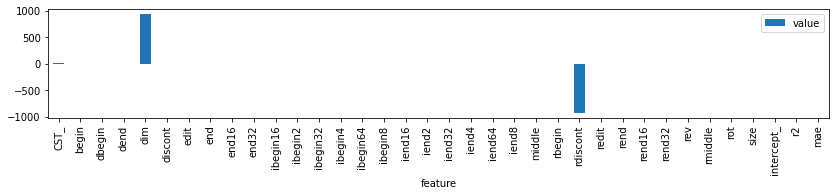

In [28]:
df = DataFrame([(k, v) for k, v in coef.items() if k not in {'name', 'model'}],
                columns=["feature", "value"]).set_index("feature")
df.plot(kind="bar", figsize=(14, 2));

In [29]:
df

,value
feature,
CST_,7.237821
begin,-0.102815
dbegin,-0.344885
dend,-0.358411
dim,934.391039
discont,-0.052681
edit,1.148297
end,3.152431
end16,-0.249016


Coefficients associated to features *end*, *end16* are almost opposed and it would better to get a model which keeps only one.

### Quantile Regression

In [30]:
from mlinsights.mlmodel import QuantileLinearRegression
pipe = make_pipeline(StandardScaler(with_mean=False), QuantileLinearRegression(fit_intercept=False))
pipe.fit(X, yt)
model = pipe.steps[1][1]
coef = {k: v for k, v in zip(X.columns, model.coef_)}
coef['name'] = 'med'
coef['intercept_'] = model.intercept_
pred = numpy.maximum(pipe.predict(X), 0)
coef['r2'] = r2_score(yt, pred)
coef['mae'] = mean_absolute_error(yt, pred)
coef['model'] = pipe
coefs.append(coef)
coef["r2"], coef['mae']

(0.7324795529390371, 0.7920623772676625)

In [31]:
DataFrame(coef.items(), columns=["feature", "value"]).set_index("feature")

,value
feature,
CST_,8.152253
begin,1.308064
dbegin,-0.236967
dend,-0.279271
dim,485.95215
discont,-0.000947
edit,0.849924
end,1.722245
end16,-0.065092


### Lasso

To select features.

In [32]:
from sklearn.linear_model import Lasso

scores = []
models = []
for a in tqdm([0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1., 2.]):
    alpha = a * 1.
    pipe = make_pipeline(StandardScaler(with_mean=False), Lasso(alpha=alpha, fit_intercept=False))
    pipe.fit(X, yt)
    pred = numpy.maximum(pipe.predict(X), 0)
    model = pipe.steps[1][1]
    scores.append(dict(r2=r2_score(yt, pred), mae=mean_absolute_error(yt, pred),
                       alpha=alpha, null=(numpy.abs(model.coef_) < 1e-6).sum(),
                       n=len(model.coef_)))
    models.append(pipe)
    if alpha >= 0.01 and alpha <= 0.2:
        coef = {k: v for k, v in zip(X.columns, pipe.steps[1][1].coef_)}
        coef['name'] = "Lasso-%f" % alpha
        coef['model'] = pipe
        coef['r2'] = r2_score(yt, pred)
        coef['mae'] = mean_absolute_error(yt, pred)
        coefs.append(coef)
    
DataFrame(scores)

  0%|          | 0/13 [00:00<?, ?it/s]c:\python395_x64\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 992.003834253147, tolerance: 2.90281374731652
  model = cd_fast.enet_coordinate_descent(
c:\python395_x64\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 208.55531208644084, tolerance: 2.90281374731652
  model = cd_fast.enet_coordinate_descent(
100%|██████████| 13/13 [00:00<00:00, 30.31it/s]


,r2,mae,alpha,null,n
0,0.746331,0.823578,0.001,4,33
1,0.744263,0.825817,0.010,14,33
2,0.720892,0.852557,0.100,25,33
3,0.700329,0.901882,0.200,28,33
4,0.695697,0.910275,0.300,28,33
5,0.688707,0.923942,0.400,27,33
6,0.670646,0.966847,0.500,26,33
7,0.647664,1.016294,0.600,26,33
8,0.620695,1.069514,0.700,26,33
9,0.595255,1.117230,0.800,28,33


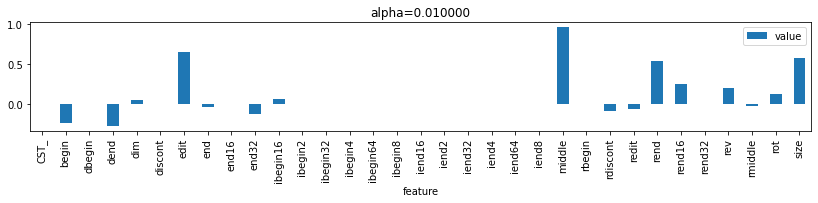

In [33]:
coef = {k: v for k, v in zip(X.columns, models[1].steps[1][1].coef_)}
df = DataFrame(coef.items(), columns=["feature", "value"]).set_index("feature")
df.plot(kind="bar", figsize=(14, 2), title="alpha=%f" % scores[1]["alpha"]);

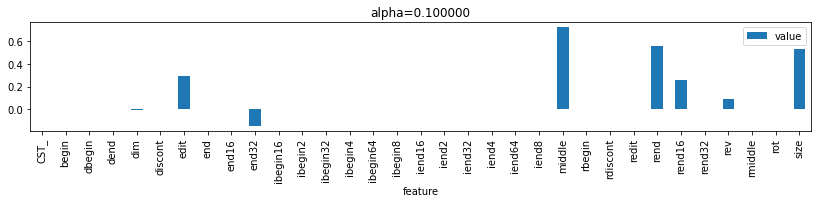

In [34]:
coef = {k: v for k, v in zip(X.columns, models[2].steps[1][1].coef_)}
df = DataFrame(coef.items(), columns=["feature", "value"]).set_index("feature")
df.plot(kind="bar", figsize=(14, 2), title="alpha=%f" % scores[2]["alpha"]);

### Linear regression with positive weights

In [35]:
pipe = make_pipeline(StandardScaler(with_mean=False), LinearRegression(positive=True, fit_intercept=False))
pipe.fit(X, yt)
model = pipe.steps[1][1]
coef = {k: v for k, v in zip(X.columns, model.coef_)}
coef['name'] = 'pos'
coef['intercept_'] = model.intercept_
pred = numpy.maximum(pipe.predict(X), 0)
coef['r2'] = r2_score(yt, pred)
coef['mae'] = mean_absolute_error(yt, pred)
coef['model'] = pipe
coefs.append(coef)
coef["r2"], coef['mae']

(0.7335971226449354, 0.8444529293022096)

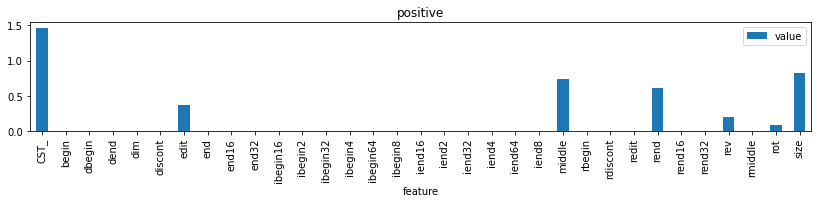

In [36]:
coef = {k: v for k, v in zip(X.columns, pipe.steps[1][1].coef_)}
df = DataFrame(coef.items(), columns=["feature", "value"]).set_index("feature")
df.plot(kind="bar", figsize=(14, 2), title="positive");

### Quantile regression with positive weights

In [37]:
pipe = make_pipeline(StandardScaler(with_mean=False), QuantileLinearRegression(positive=True, fit_intercept=False))
pipe.fit(X, yt)
model = pipe.steps[1][1]
coef = {k: v for k, v in zip(X.columns, model.coef_)}
coef['name'] = 'medpos'
coef['intercept_'] = model.intercept_
pred = numpy.maximum(pipe.predict(X), 0)
coef['r2'] = r2_score(yt, pred)
coef['mae'] = mean_absolute_error(yt, pred)
coef['model'] = pipe
coefs.append(coef)
coef["r2"], coef['mae']

(0.7188040046662618, 0.8198663814796678)

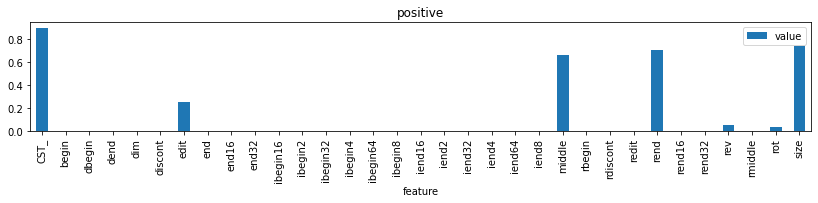

In [38]:
coef = {k: v for k, v in zip(X.columns, pipe.steps[1][1].coef_)}
df = DataFrame(coef.items(), columns=["feature", "value"]).set_index("feature")
df.plot(kind="bar", figsize=(14, 2), title="positive");

### Summary

In [39]:
dfcoef = DataFrame(coefs)
dfcoef[::-1].T

,6,5,4,3,2,1,0
CST_,0.899124,1.466345,0.0,0.0,0.0,8.152253,7.237821
begin,0.0,0.0,-0.0,-0.0,-0.242802,1.308064,-0.102815
dbegin,0.0,0.0,-0.0,-0.0,-0.0,-0.236967,-0.344885
dend,0.0,0.0,-0.0,-0.0,-0.279661,-0.279271,-0.358411
dim,0.0,0.0,-0.0,-0.004505,0.045219,485.95215,934.391039
discont,0.0,0.0,0.0,0.0,0.0,-0.000947,-0.052681
edit,0.249947,0.367983,0.169891,0.29243,0.647878,0.849924,1.148297
end,0.0,0.0,0.0,-0.0,-0.042511,1.722245,3.152431
end16,0.0,0.0,-0.0,-0.0,-0.0,-0.065092,-0.249016
end32,0.0,0.0,-0.0,-0.149017,-0.122501,0.115187,0.124704


## Investigation

In [40]:
data_err = data.drop(["context_size", "repeat"], axis=1).copy()
data_err['predict'] = numpy.maximum(coefs[0]['model'].predict(X), 0) / 1000
data_err['err'] = (data_err['predict'] - data_err['average'])
data_err['abserr'] = numpy.abs(data_err['predict'] - data_err['average'])
data_err['rel'] = (data_err['predict'] - data_err['average']) / data_err['average']
s = data_err.sort_values('abserr')
pandas.concat([s.head(n=10), s.tail(n=10)])

,average,deviation,min_exec,max_exec,number,perm,shape,ratio,dim,predict,err,abserr,rel
1088,0.001566,0.000100,0.001505,0.001765,5,"(0, 1, 3, 2, 4)","(4, 21, 19, 24, 19)",0.936712,5,0.001564,-0.000002,0.000002,-0.001286
25,0.000069,0.000015,0.000052,0.000111,50,"(0, 1, 2)","(43, 44, 45)",1.000000,3,0.000066,-0.000002,0.000002,-0.033533
654,0.002217,0.000234,0.001852,0.002617,7,"(3, 1, 4, 2, 0)","(3, 16, 16, 21, 20)",3.074576,5,0.002212,-0.000005,0.000005,-0.002235
1384,0.001838,0.000299,0.001625,0.002430,5,"(0, 1, 3, 2)","(3, 183, 17, 57)",1.123662,4,0.001843,0.000006,0.000006,0.003045
252,0.002457,0.000364,0.002044,0.002932,7,"(2, 3, 0, 1)","(3, 77, 48, 38)",2.988783,4,0.002452,-0.000006,0.000006,-0.002277
24,0.000064,0.000007,0.000058,0.000080,50,"(1, 0, 2)","(43, 44, 45)",0.929465,3,0.000058,-0.000006,0.000006,-0.088652
1156,0.004639,0.000521,0.004121,0.005581,5,"(3, 1, 2, 4, 0)","(4, 21, 19, 24, 19)",2.774277,5,0.004631,-0.000008,0.000008,-0.001825
1432,0.000186,0.000066,0.000118,0.000348,10,"(1, 0, 2)","(38, 168, 19)",2.448337,3,0.000196,0.000010,0.000010,0.053063
973,0.002055,0.000276,0.001890,0.002605,5,"(1, 0, 2, 3, 4)","(3, 25, 31, 18, 19)",1.258473,5,0.002066,0.000011,0.000011,0.005198
123,0.002726,0.000235,0.002436,0.002977,5,"(0, 2, 4, 3, 1)","(3, 21, 20, 19, 21)",1.095229,5,0.002715,-0.000011,0.000011,-0.004150


All big errors are negative. The model seems to give a lower value for all big errors. These errors may be outliers, the processor was busy doing something else at that time.

In [41]:
s = data_err.sort_values('predict')
pandas.concat([s.head(n=10), s.tail(n=10)])

,average,deviation,min_exec,max_exec,number,perm,shape,ratio,dim,predict,err,abserr,rel
1402,0.000034,0.000005,0.000031,0.000050,10,"(0, 1, 2)","(41, 3, 48)",1.000000,3,0.000000,-0.000034,0.000034,-1.000000
687,0.000033,0.000004,0.000031,0.000045,10,"(1, 0, 2)","(52, 22, 16)",1.005259,3,0.000000,-0.000033,0.000033,-1.000000
1404,0.000047,0.000007,0.000045,0.000067,10,"(0, 1, 2)","(8, 122, 50)",1.000000,3,0.000000,-0.000047,0.000047,-1.000000
1405,0.000050,0.000006,0.000047,0.000068,10,"(1, 0, 2)","(8, 122, 50)",1.059739,3,0.000000,-0.000050,0.000050,-1.000000
1406,0.000053,0.000006,0.000050,0.000070,10,"(1, 2, 0)","(8, 122, 50)",1.120604,3,0.000000,-0.000053,0.000053,-1.000000
1408,0.000061,0.000007,0.000056,0.000080,10,"(2, 0, 1)","(8, 122, 50)",1.286728,3,0.000000,-0.000061,0.000061,-1.000000
229,0.000029,0.000004,0.000026,0.000039,10,"(2, 0, 1)","(3, 210, 12)",0.717805,3,0.000000,-0.000029,0.000029,-1.000000
1410,0.000035,0.000006,0.000032,0.000052,10,"(1, 2, 0)","(34, 19, 35)",0.983015,3,0.000000,-0.000035,0.000035,-1.000000
1411,0.000035,0.000006,0.000033,0.000054,10,"(0, 1, 2)","(34, 19, 35)",1.000000,3,0.000000,-0.000035,0.000035,-1.000000
1413,0.000040,0.000009,0.000034,0.000058,10,"(0, 2, 1)","(34, 19, 35)",1.141410,3,0.000000,-0.000040,0.000040,-1.000000


### Correlation between predictors

In [42]:
cc = DataFrame(dict([(c['name'], numpy.maximum(c['model'].predict(X), 0)) for c in coefs]))
cc['yt'] = yt
cc

,reg,med,Lasso-0.010000,Lasso-0.100000,Lasso-0.200000,pos,medpos,yt
0,0.022559,0.051774,0.009958,0.076228,0.484923,0.000000,0.000000,0.051760
1,0.000000,0.000000,0.000000,0.154116,0.565801,0.000000,0.000000,0.055190
2,0.000000,0.000000,0.000000,0.069692,0.478136,0.000000,0.000000,0.064109
3,0.000000,0.000000,0.000000,0.154116,0.565801,0.000000,0.000000,0.066292
4,0.022559,0.051774,0.009958,0.076228,0.484923,0.000000,0.000000,0.071005
...,...,...,...,...,...,...,...,...
1429,0.198284,0.241245,0.512359,0.431129,0.794524,0.105495,0.265627,0.111006
1430,0.000000,0.000000,0.000000,0.669379,1.041921,0.039423,0.360010,0.116482
1431,0.000000,0.000000,0.000000,0.669379,1.041921,0.039423,0.360010,0.165374
1432,0.195927,0.262007,0.097460,0.238817,0.614665,0.000000,0.040980,0.186054


In [43]:
cc.corr()

,reg,med,Lasso-0.010000,Lasso-0.100000,Lasso-0.200000,pos,medpos,yt
reg,1.000000,0.995642,0.998590,0.989469,0.981899,0.992842,0.987356,0.865054
med,0.995642,1.000000,0.995542,0.995462,0.992548,0.994104,0.995146,0.859603
Lasso-0.010000,0.998590,0.995542,1.000000,0.992564,0.985330,0.995370,0.990462,0.863176
Lasso-0.100000,0.989469,0.995462,0.992564,1.000000,0.997829,0.996587,0.998656,0.852407
Lasso-0.200000,0.981899,0.992548,0.985330,0.997829,1.000000,0.991618,0.998173,0.845230
pos,0.992842,0.994104,0.995370,0.996587,0.991618,1.000000,0.995772,0.857056
medpos,0.987356,0.995146,0.990462,0.998656,0.998173,0.995772,1.000000,0.851184
yt,0.865054,0.859603,0.863176,0.852407,0.845230,0.857056,0.851184,1.000000


## Standalone predictions

In [44]:
def get_coef(pipe, names):
    c1 = pipe.steps[0][-1].scale_
    c2 = pipe.steps[1][-1].coef_
    return dict(zip(names, c2 / c1))


get_coef(coefs[-1]["model"], X.columns)

{'CST_': 0.8991239004428176,
 'begin': 0.0,
 'dbegin': 0.0,
 'dend': 0.0,
 'dim': 0.0,
 'discont': 0.0,
 'edit': 0.22988973076187402,
 'end': 0.0,
 'end16': 0.0,
 'end32': 0.0,
 'ibegin16': 0.0,
 'ibegin2': 0.0,
 'ibegin32': 0.0,
 'ibegin4': 0.0,
 'ibegin64': 0.0,
 'ibegin8': 0.0,
 'iend16': 0.0,
 'iend2': 0.0,
 'iend32': 0.0,
 'iend4': 0.0,
 'iend64': 0.0,
 'iend8': 0.0,
 'middle': 1.8558099427371573e-06,
 'rbegin': 0.0,
 'rdiscont': 0.0,
 'redit': 0.0,
 'rend': 2.0064975114023806e-06,
 'rend16': 0.0,
 'rend32': 0.0,
 'rev': 0.3357283613823943,
 'rmiddle': 0.0,
 'rot': 0.12479548136361247,
 'size': 2.727803959655398e-06}

In [45]:
def predict(coefs, shape, perm):
    feat = compute_features(shape, perm)
    res = 0
    for k, v in feat.items():
        res += v * coefs[k]
    return res / 1000


def predict_model(model, shape, perm, names):
    feat = compute_features(shape, perm)
    a = numpy.zeros((1, len(names)), dtype=numpy.float64)
    for i, n in enumerate(names):
        a[0, i] = feat[n]
    return model.predict(a) / 1000
    

coef = get_coef(coefs[-1]["model"], X.columns)
(predict(coef, (3, 224, 224, 6), (3, 0, 1, 2)), 
 predict_model(coefs[-1]["model"], (3, 224, 224, 6), (3, 0, 1, 2), X.columns))

(0.0055126333064552755, array([0.00551263]))